***
# Background

Valve is always looking for new games to produce and sell and this time they are eager to analyze their data to find some insights into what makes a successful game. 

***
# Objectives

1. Find **insights into what makes a successful game**
2. Conduct an experiment to see if we can use their data to **predict the next popular game**
3. Develop a predictive model to **predict what type of game will be successful at what price**


***
# Assumptions

- Focus on Paid games
- Free games are out of scope
- Demos, SDKs, mods and dlcs are out of scope

***
# Load Packages and Setup Environment

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

from pathlib import Path

from analytics_translators import configs

In [2]:
%matplotlib inline

In [3]:
if not Path(configs.DIR_OUTPUT).exists():
    Path(configs.DIR_OUTPUT).mkdir()

In [4]:
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

pd.set_option('display.max_rows', 350)

***
# Data Importing and Preview 

## Game Data

### Application Information  (`applicationInformation`)

In [5]:
from analytics_translators.utils.misc import parser

file_path = Path(configs.DIR_DATA) / 'applicationInformation.csv'
df_app_info = pd.read_csv(file_path, encoding='latin-1', parse_dates=['releasedate'], date_parser=parser)

In [6]:
df_game_info = df_app_info[
    (df_app_info['appid'].notnull()) & 
    (df_app_info['type'] == 'game') & 
    (df_app_info['freetoplay'] == 0) & 
    (df_app_info['releasedate'].notnull()) 
    ] \
    .drop(['type', 'freetoplay'], axis=1) \
    .astype({'appid': str})
    
game_ids = df_game_info.appid.unique().tolist()

In [7]:
display(df_game_info.head())
display(df_game_info.tail())

,appid,name,releasedate
0,578080,PLAYERUNKNOWN'S BATTLEGROUNDS,2017-12-21
4,359550,Tom Clancy's Rainbow Six Siege,2015-12-01
5,271590,Grand Theft Auto V,2015-04-13
9,252950,Rocket League,2015-07-07
10,252490,Rust,2018-02-08


,appid,name,releasedate
1993,64000,Men of War: Assault Squad,2011-02-24
1994,227860,Castle Story,2017-08-17
1997,429050,Feed and Grow: Fish,2016-01-08
1998,209650,Call of Duty: Advanced Warfare,2014-11-03
1999,304730,Train Fever,2014-09-04


In [8]:
display(df_game_info.releasedate.describe(datetime_is_numeric=True))

count                             1495
mean     2014-12-06 23:22:26.086956544
min                1998-11-08 00:00:00
25%                2013-10-21 00:00:00
50%                2015-11-19 00:00:00
75%                2017-02-07 12:00:00
max                2019-03-07 00:00:00
Name: releasedate, dtype: object

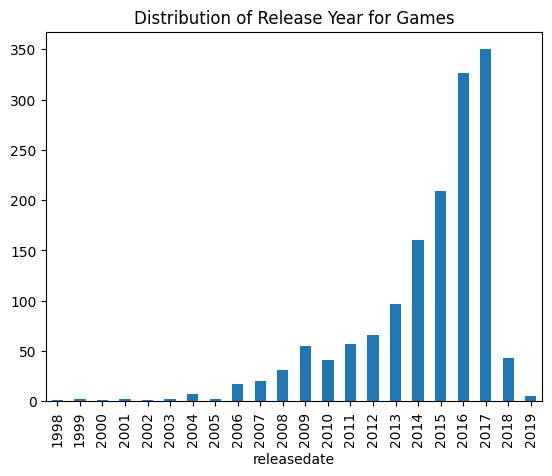

In [9]:
df_game_info['releasedate'] \
    .groupby(df_game_info.releasedate.dt.year) \
    .count() \
    .plot(kind='bar')

plt.title('Distribution of Release Year for Games')
plt.show()

### Application Genre, Developers, Publishers, and Tags

In [10]:
import re
from collections import defaultdict

from analytics_translators.utils.text import clean_text
from analytics_translators.process.data_processor import DataProcessor

In [11]:
def data_dict_summary(data_dict: dict, data_desc: str) -> None:
    
        print(f'\tThere are {np.sum(data_dict[data_desc]["df"].isna().sum())} missing values in \'{data_desc}\'')
        print(f'\tThere are {len(data_dict[data_desc]["count"].keys())} unique labels in \'{data_desc}\'')
        print(f'\tThere most common labels are: {data_dict[data_desc]["count"].most_common(10)}')        

In [12]:
# Save application data into a dictionary with the source as the key
data_dict = defaultdict(dict)
files_exclude = ['applicationSupportedlanguages', 'applicationInformation', 'applicationPackages']

p = Path(configs.DIR_DATA)

for f in p.glob('application*.csv'):
    if f.stem in files_exclude:
        print(f'Skipped: {f}')
        next
    else:
        data_desc = f.stem.strip('application').lower()
        print(f'Processing \'{data_desc}\': {f}')
        
        dp = DataProcessor(
            path=f,
            include=game_ids,
        )

        dp.load_dataset()
        dp.get_entities_list()
        
        data_dict[data_desc]['df'] = dp.save_as_dataframe()
        data_dict[data_desc]['all'] = dp.all_entities
        data_dict[data_desc]['count'] = dp.entities_count 
        
        data_dict_summary(data_dict, data_desc)

Skipped: Data/applicationPackages.csv
Skipped: Data/applicationInformation.csv
Processing 'developers': Data/applicationDevelopers.csv
	There are 0 missing values in 'developers'
	There are 1037 unique labels in 'developers'
	There most common labels are: [('FERAL_INTERACTIVE', 62), ('ASPYR', 23), ('VALVE', 17), ('FIRAXIS_GAMES', 14), ('SQUARE_ENIX', 14), ('KOEI_TECMO_GAMES_CO', 14), ('TRAVELLERS_TALES', 14), ('UBISOFT_MONTREAL', 12), ('CREATIVE_ASSEMBLY', 12), ('RELIC_ENTERTAINMENT', 12)]
Processing 'publishers': Data/applicationPublishers.csv
	There are 0 missing values in 'publishers'
	There are 687 unique labels in 'publishers'
	There most common labels are: [('FERAL_INTERACTIVE', 62), ('UBISOFT', 47), ('SEGA', 42), ('2K', 33), ('SQUARE_ENIX', 33), ('ASPYR', 26), ('PARADOX_INTERACTIVE', 26), ('BETHESDA_SOFTWORKS', 25), ('ACTIVISION', 25), ('ELECTRONIC_ARTS', 25)]
Processing 'genres': Data/applicationGenres.csv
	There are 0 missing values in 'genres'
	There are 26 unique labels in '

### Application Language

In [13]:
dp = DataProcessor(
    path=Path(configs.DIR_DATA) / 'applicationSupportedlanguages.csv',
    include=game_ids,
    )

dp.load_dataset(line_pattern='\\s{2,}')
dp.get_entities_list()

data_dict['language']['df'] = dp.save_as_dataframe()
data_dict['language']['all'] = dp.all_entities
data_dict['language']['count'] = dp.entities_count 

data_dict_summary(data_dict, 'language')

	There are 0 missing values in 'language'
	There are 30 unique labels in 'language'
	There most common labels are: [('ENGLISH', 1487), ('GERMAN', 961), ('FRENCH', 939), ('SPANISH_SPAIN', 888), ('ITALIAN', 764), ('RUSSIAN', 752), ('POLISH', 515), ('JAPANESE', 464), ('SIMPLIFIED_CHINESE', 449), ('PORTUGUESE_BRAZIL', 398)]


### Subset With Most Common Values

In [14]:
# Create a smaller dataframe for each data source with only the N most common labels
for data_desc in data_dict.keys():
    
    print(f'Creating a subset with the {configs.MOST_COMMON_THRESHOLD[data_desc]} most common {data_desc}')
    
    most_common_values = data_dict[data_desc]['count'].most_common(configs.MOST_COMMON_THRESHOLD[data_desc])
    most_common_values_list = [ent[0] for ent in most_common_values]

    data_dict[data_desc]['df_subset'] = data_dict[data_desc]['df'][most_common_values_list]

Creating a subset with the 50 most common developers
Creating a subset with the 50 most common publishers
Creating a subset with the 50 most common genres
Creating a subset with the 50 most common tags
Creating a subset with the 10 most common language


There is a significant amount of overlap between the publishers and the developers (ca. 75%).

In [15]:
developers_publishers_overlap = np.mean(
    data_dict['publishers']['df'].columns.isin(data_dict['developers']['df'].columns)
    )
print(f'{developers_publishers_overlap*100:.2f}% overlap between labels of developers and publishers')

74.53% overlap between labels of developers and publishers


## Player Count History

In [16]:
from analytics_translators.process.count_processor import CountProcessor

In [17]:
# Process player count history by importing files and aggregating players counts to average counts per day
count_data = {}

for sub_dir in ['PlayerCountHistoryPart1', 'PlayerCountHistoryPart2']:
    
    path = Path(configs.DIR_DATA) / sub_dir
    print(f'Processing files in {sub_dir}')

    for file in [f for f in path.glob('*.csv')]:
        if file.stem in game_ids:
            
            cp = CountProcessor(path=file)

            cp.load_dataset(index_col='Time', parse_dates=['Time'], header=0)
            cp.fill_missing_values(method=configs.TIMESERIES_FILLING_METHOD)
            cp.aggregate_values(aggregate_by=configs.TIMESERIES_AGGREGATE_GRANULARITY)

            count_data[file.stem] = cp.get_data()
        
        else:
            next

Processing files in PlayerCountHistoryPart1
Processing files in PlayerCountHistoryPart2


In [18]:
display(count_data['10'].head())
display(count_data['10'].tail())

,Playercount
Time,
2017-12-14,12046.0
2017-12-15,12659.0
2017-12-16,14011.0
2017-12-17,14502.0
2017-12-18,12615.0


,Playercount
Time,
2020-08-08,10940.0
2020-08-09,11415.0
2020-08-10,10516.0
2020-08-11,10572.0
2020-08-12,10287.0


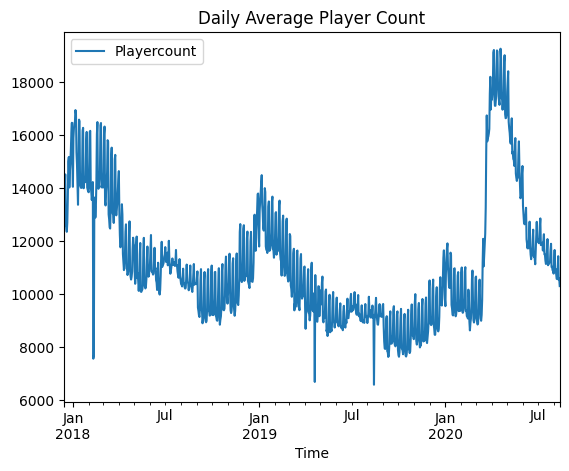

In [19]:
count_data['10'].plot()
plt.title('Daily Average Player Count')
plt.show()

## Price History

In [20]:
from analytics_translators.process.price_processor import PriceProcessor

In [21]:
# Process game price history by importing files and forward fill any missing values
price_data = defaultdict(pd.DataFrame)

path = Path(configs.DIR_DATA) / 'PriceHistory'
for file in [f for f in path.glob('*.csv')]:
    if file.stem in game_ids:
        
        pp = PriceProcessor(path=file)
        pp.load_dataset(index_col='Date', parse_dates=['Date'], header=0)
        pp.fill_missing_values(method=configs.TIMESERIES_FILLING_METHOD)
        
        price_data[file.stem] = pp.get_data()[['Initialprice', 'Finalprice', 'Discount']]
    
    else:
        next

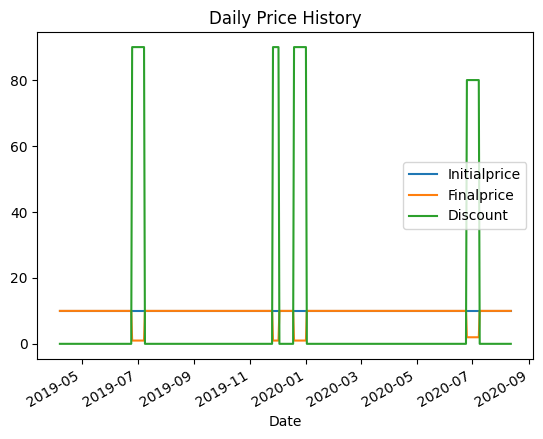

In [22]:
price_data['10'].plot()
plt.title('Daily Price History')
plt.show()

## Create Statistical Features

In [23]:
from analytics_translators.process.feature_creator import FeatureCreator

In [24]:
games_ids_full_data = list({*count_data.keys()}.intersection({*price_data.keys()}))

print(f'There are {len(games_ids_full_data)} games with both player count and price data')

There are 1063 games with both player count and price data


In [25]:
# Create feature array of statistics from price, discount and player count data
df_features = pd.DataFrame()

for game_id in games_ids_full_data:
    
    fc = FeatureCreator(
        id=game_id, 
        id_col='appid', 
        game_data=df_game_info, 
        count_data=count_data, 
        price_data=price_data,
        date_col='releasedate',
        name_col='name',
        timeframe_days=365
        )
    fc.create_discount_features()
    fc.create_statistical_features(
        funcs=configs.FEATURE_STATISTICAL_FUNCTIONS, 
        fields=configs.FEATURE_STATISTICAL_FIELDS
        )
    fc.create_age_feature()
    
    df_features = pd.concat([df_features, fc.features], axis=0)

In [26]:
display(df_features.head())

,age_days,discount_time_perc,discount_time_count,discount_min,discount_mean,discount_max,price_min,price_mean,price_max,count_min,count_mean,count_max
420,4325,0.106557,4.0,0.0,9.207650,90.0,0.79,7.253388,7.99,94.0,260.087432,961.0
552100,1009,0.098901,4.0,0.0,2.967033,30.0,10.49,14.544945,14.99,352.0,650.521978,938.0
361280,1167,0.117808,6.0,0.0,7.024658,80.0,2.00,9.287589,9.99,92.0,324.054795,3692.0
552700,630,0.112637,5.0,0.0,5.631868,50.0,12.49,23.582033,24.99,23.0,60.989011,212.0
262280,1572,0.153005,7.0,0.0,11.857923,80.0,3.99,17.618415,19.99,30.0,56.098361,178.0


In [27]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1063 entries, 420 to 528300
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age_days             1063 non-null   int64  
 1   discount_time_perc   1054 non-null   float64
 2   discount_time_count  1054 non-null   float64
 3   discount_min         1054 non-null   float64
 4   discount_mean        1054 non-null   float64
 5   discount_max         1054 non-null   float64
 6   price_min            1054 non-null   float64
 7   price_mean           1054 non-null   float64
 8   price_max            1054 non-null   float64
 9   count_min            1054 non-null   float64
 10  count_mean           1054 non-null   float64
 11  count_max            1054 non-null   float64
dtypes: float64(11), int64(1)
memory usage: 108.0+ KB


In [28]:
df_features.describe()

,age_days,discount_time_perc,discount_time_count,discount_min,discount_mean,discount_max,price_min,price_mean,price_max,count_min,count_mean,count_max
count,1063.000000,1054.000000,1054.000000,1054.0,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000
mean,1693.387582,0.160368,6.963947,0.0,10.382201,66.134725,5.963786,16.301785,18.588197,264.615750,511.715914,1432.107211
std,1087.886857,0.067861,3.021234,0.0,5.460931,19.525785,6.288226,12.343099,14.072364,1949.576035,3411.129219,6526.040591
min,166.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.490000,0.817397,0.990000,0.000000,0.000000,0.000000
25%,923.000000,0.123288,5.000000,0.0,7.056123,51.000000,1.990000,8.443691,9.990000,13.000000,36.329235,142.000000
50%,1351.000000,0.155951,7.000000,0.0,10.068400,75.000000,4.990000,14.690000,15.490000,44.000000,100.300546,355.000000
75%,2095.000000,0.193989,9.000000,0.0,13.192062,80.000000,7.490000,21.273640,24.990000,120.000000,260.279413,977.750000
max,7583.000000,0.520548,16.500000,0.0,45.736986,100.000000,66.990000,97.170328,99.990000,50977.000000,84074.372603,145209.000000


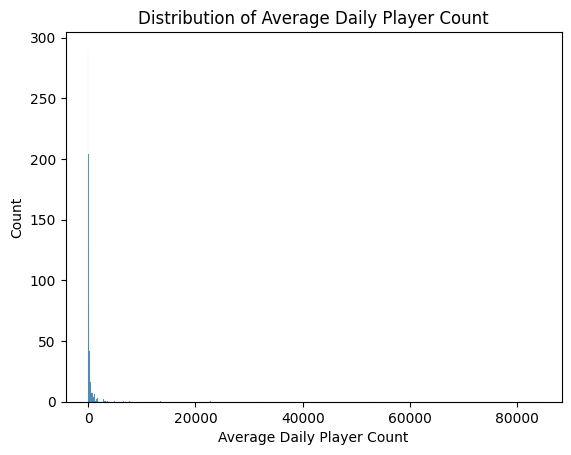

In [29]:
sns.histplot(df_features['count_mean'])
plt.xlabel('Average Daily Player Count')
plt.title('Distribution of Average Daily Player Count')
plt.show()

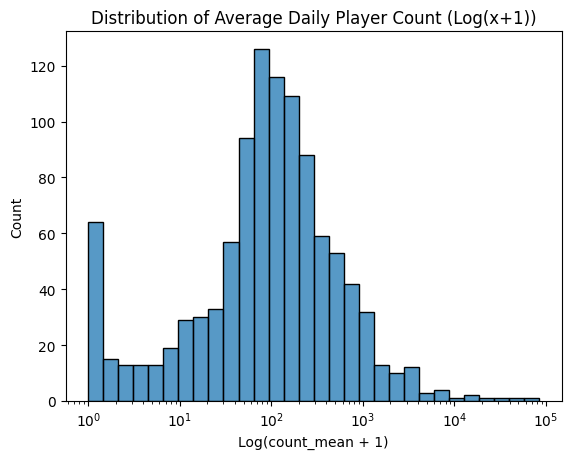

In [30]:
sns.histplot(df_features['count_mean']+1, log_scale=True)
plt.xlabel('Log(count_mean + 1)')
plt.title('Distribution of Average Daily Player Count (Log(x+1))')
plt.show()

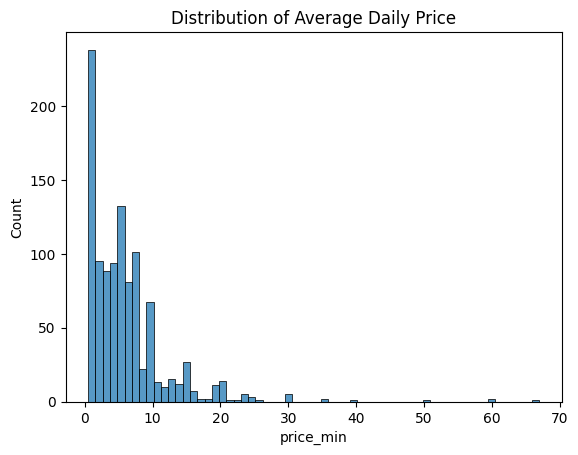

In [31]:
sns.histplot(df_features, x='price_min')
plt.title('Distribution of Average Daily Price')
plt.show()

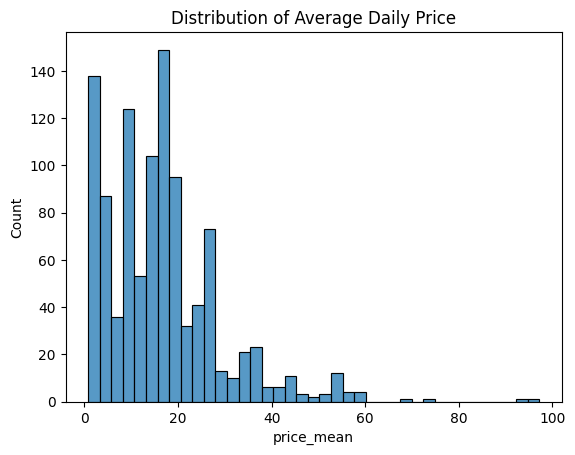

In [32]:
sns.histplot(df_features, x='price_mean')
plt.title('Distribution of Average Daily Price')
plt.show()

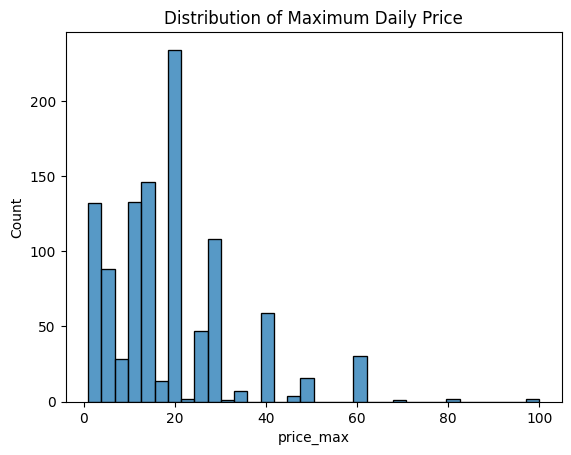

In [33]:
sns.histplot(df_features, x='price_max')
plt.title('Distribution of Maximum Daily Price')
plt.show()

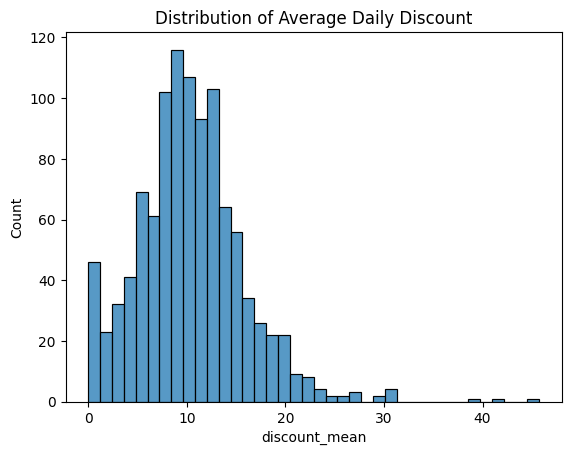

In [34]:
sns.histplot(df_features, x='discount_mean')
plt.title('Distribution of Average Daily Discount')
plt.show()

## Join Game Data

In [35]:
# Join data of summarized statistical features and application data into a single dataframe
df_all = df_features.copy()

for source in data_dict.keys():
    
    df_tmp = data_dict[source]['df_subset'].copy()
    # Standardize columns names with prefix
    df_tmp.columns = [source + '_' + col.lower().strip() for col in df_tmp.columns]
    
    df_all = pd.merge(
        left=df_all,
        right=df_tmp,
        how='left',
        left_index=True,
        right_index=True,
    )

# Export to use for modelling
df_all.to_csv(Path(configs.DIR_DATA_FILE), index=False)

In [36]:
df_all

,age_days,discount_time_perc,discount_time_count,discount_min,discount_mean,discount_max,price_min,price_mean,price_max,count_min,...,language_english,language_german,language_french,language_spanish_spain,language_italian,language_russian,language_polish,language_japanese,language_simplified_chinese,language_portuguese_brazil
420,4325,0.106557,4.0,0.0,9.207650,90.0,0.79,7.253388,7.99,94.0,...,True,True,True,True,True,True,True,True,True,False
552100,1009,0.098901,4.0,0.0,2.967033,30.0,10.49,14.544945,14.99,352.0,...,True,True,False,False,False,False,False,False,False,False
361280,1167,0.117808,6.0,0.0,7.024658,80.0,2.00,9.287589,9.99,92.0,...,True,True,True,True,True,True,True,False,True,True
552700,630,0.112637,5.0,0.0,5.631868,50.0,12.49,23.582033,24.99,23.0,...,True,True,True,True,True,False,False,True,False,False
262280,1572,0.153005,7.0,0.0,11.857923,80.0,3.99,17.618415,19.99,30.0,...,True,True,True,True,True,True,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507400,820,0.251366,11.5,0.0,19.254098,83.0,0.50,2.412377,2.99,0.0,...,True,False,False,True,False,False,False,False,False,False
467960,1167,0.156164,8.0,0.0,7.904110,55.0,2.69,5.515753,5.99,35.0,...,True,False,False,False,False,True,False,True,True,True
4560,4410,0.117808,6.0,0.0,9.397260,80.0,3.99,18.110548,19.99,57.0,...,True,True,True,True,True,True,True,True,False,False
34030,3456,0.165289,6.0,0.0,12.396694,75.0,6.24,21.890826,24.99,840.0,...,True,True,True,True,True,True,True,False,False,False


### Analyze Joined Dataset

In [37]:
print(df_all.shape)

(1063, 198)


In [38]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1063 entries, 420 to 528300
Columns: 198 entries, age_days to language_portuguese_brazil
dtypes: bool(60), float64(11), int64(1), object(126)
memory usage: 1.2+ MB


In [39]:
df_tmp = df_all.copy()
df_tmp = df_tmp.astype(float)

In [40]:
from analytics_translators.utils.plot import (
    plot_perc_missing, 
    plot_feature_correlations, 
    plot_correlation_heatmap
)

#### Missing Values

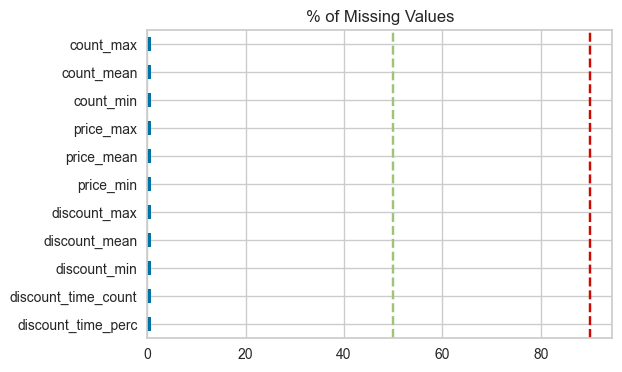

In [41]:
plot_perc_missing(df_all, dtype_include=float, figsize=(6, 4))

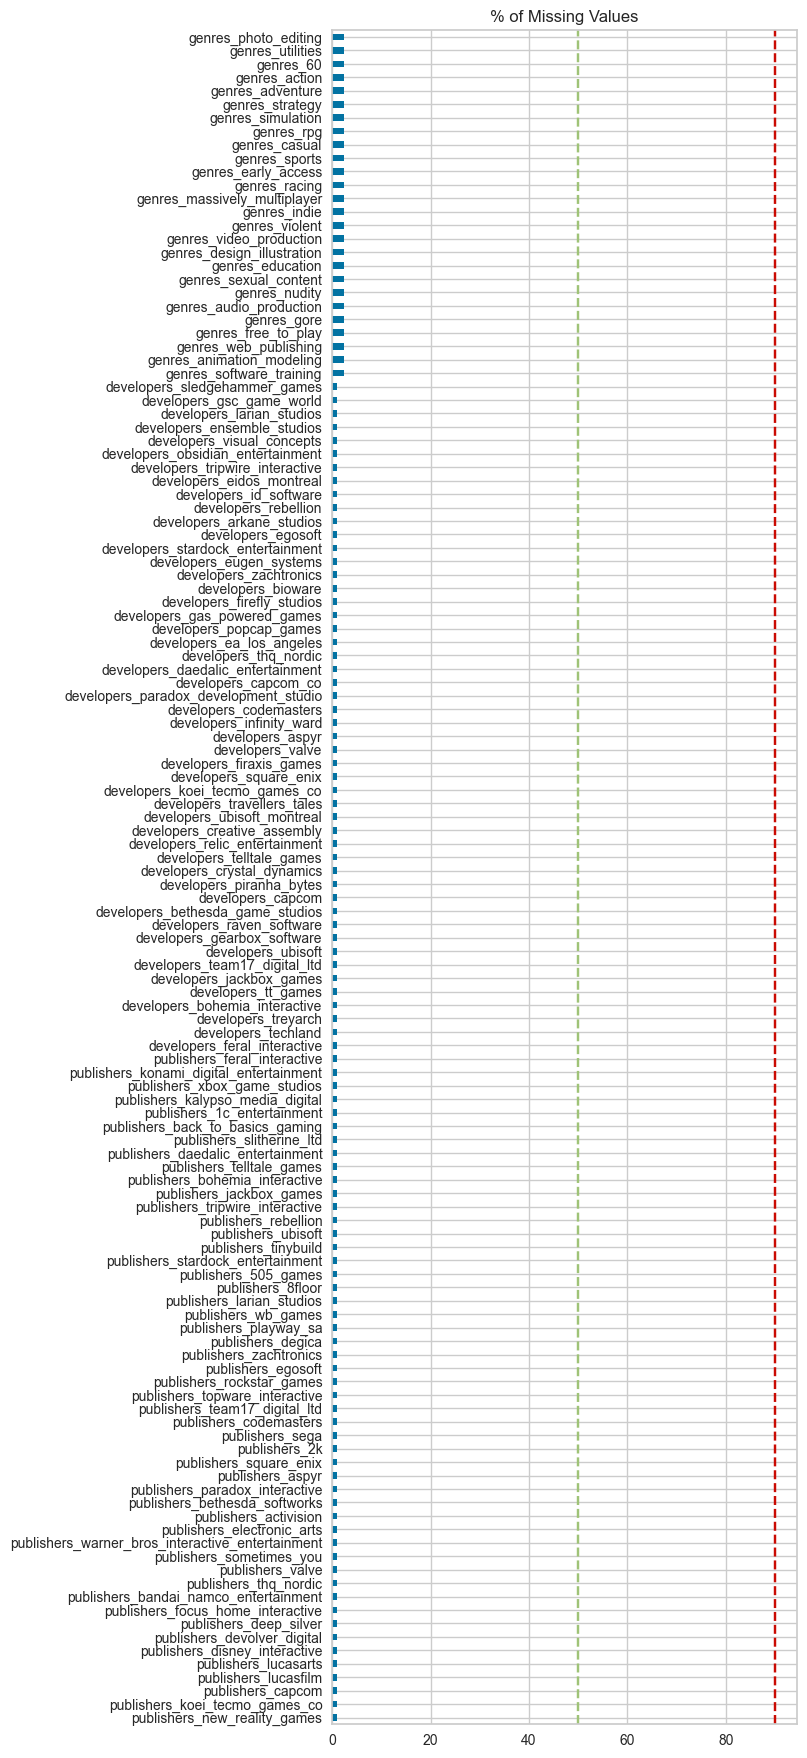

In [42]:
plot_perc_missing(df_all, dtype_include=object, figsize=(6, 22))

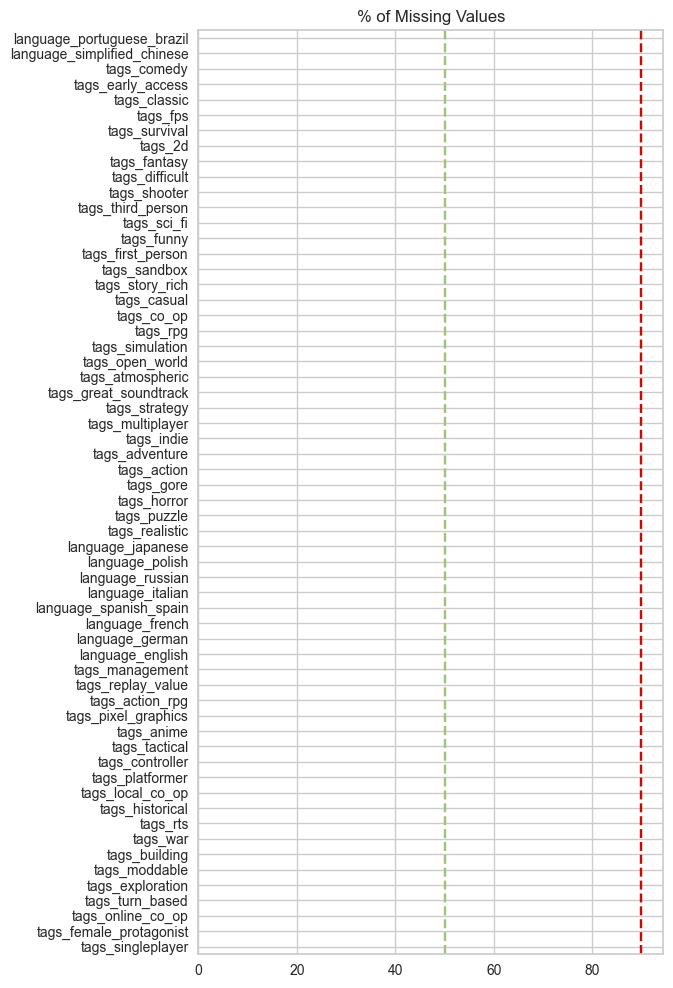

In [43]:
plot_perc_missing(df_all, dtype_include=bool, figsize=(6, 12))

### Feature Correlation

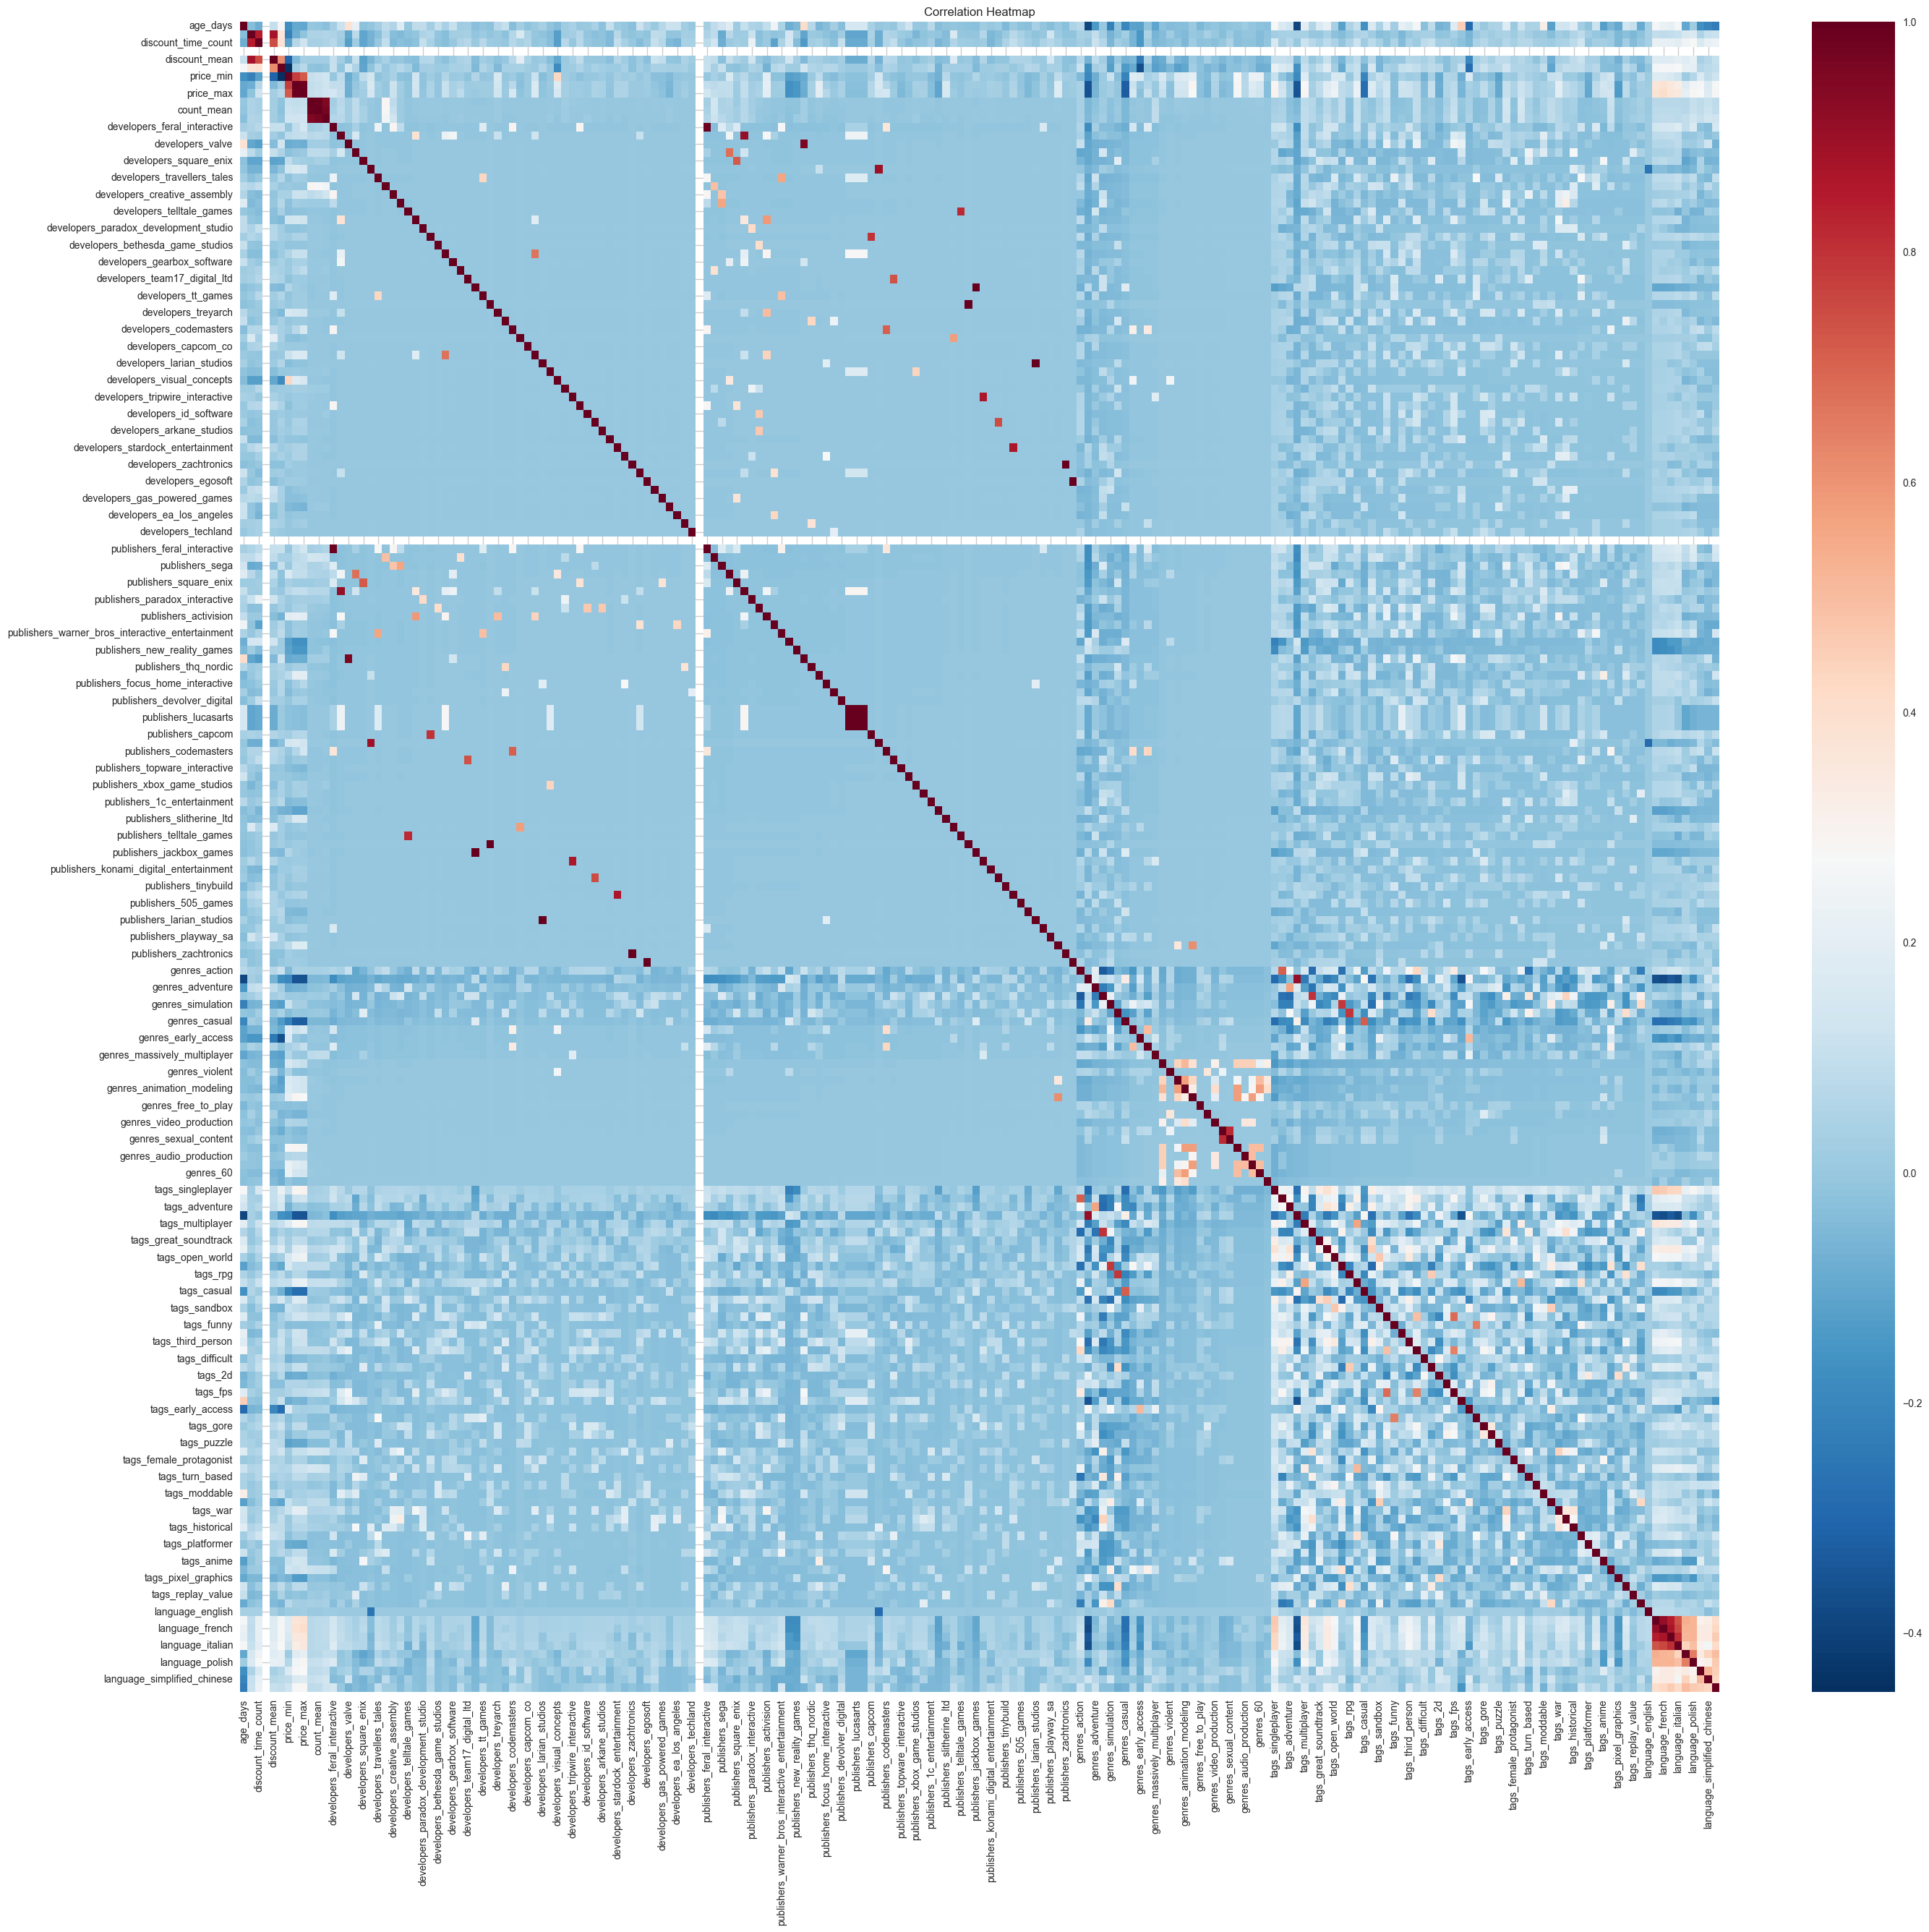

In [44]:
plot_correlation_heatmap(df_tmp, figsize=(33,30))

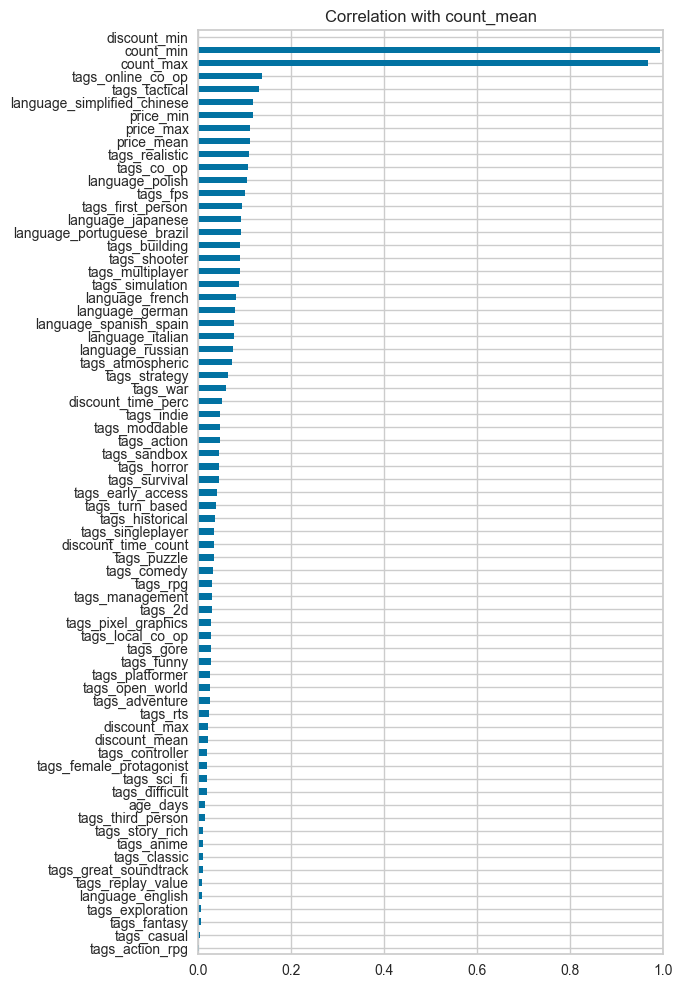

In [45]:
plot_feature_correlations(df=df_all, col_target='count_mean')

***
## Modelling

In [46]:
# Model training is done by running train.py
# python3 -W ignore train.py

__________________________________________________
price_mean


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('preprocessor',
                                              Pipeline(steps=[('bool_impute_missing',
                                                               MeanMedianImputer(variables=['developers_feral_interactive',
                                                                                            'developers_aspyr',
                                                                                            'developers_valve',
                                                                                            'developers_firaxis_games',
                                                                                            'developers_square_enix',
                                                                                            'developers_koei_tecmo_games_co',
                                                                                            'developers_travellers_tales',
                                                                                            'developers_ubisoft_montreal',
                                                                                            '...
                                        'model__regressor__n_estimators': [50,
                                                                           100]},
                   random_state=1, refit='mse',
                   scoring={'mae': make_scorer(mean_absolute_error, greater_is_better=False),
                            'max_error': make_scorer(max_error, greater_is_better=False),
                            'mse': make_scorer(mean_squared_error, greater_is_better=False, squared=True),
                            'r2': make_scorer(r2_score),
                            'rmse': make_scorer(mean_squared_error, greater_is_better=False, squared=False)})

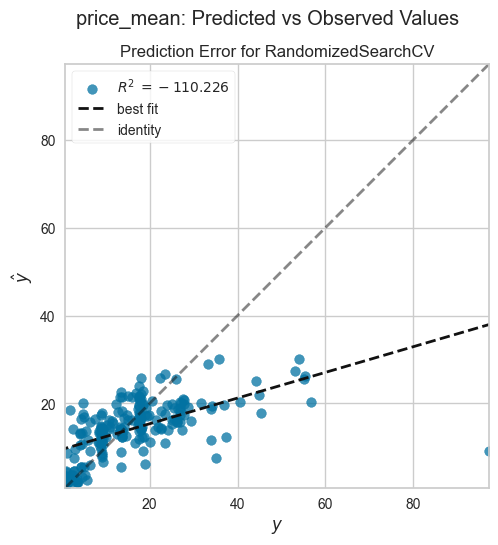

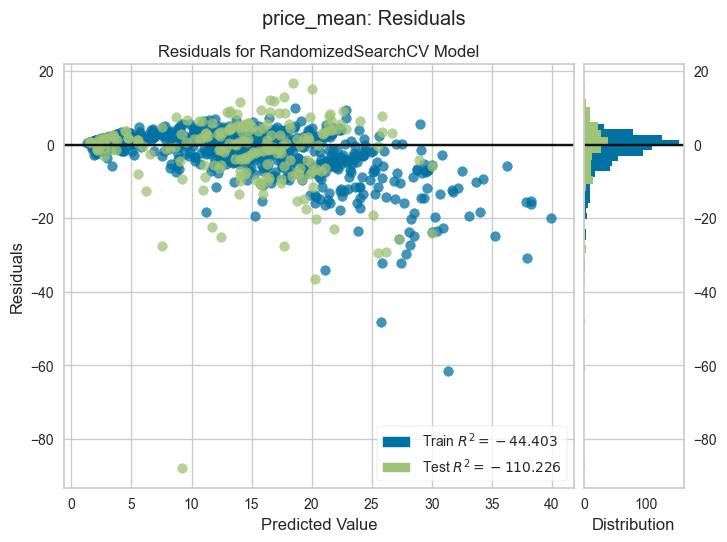

__________________________________________________
price_max


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('preprocessor',
                                              Pipeline(steps=[('bool_impute_missing',
                                                               MeanMedianImputer(variables=['developers_feral_interactive',
                                                                                            'developers_aspyr',
                                                                                            'developers_valve',
                                                                                            'developers_firaxis_games',
                                                                                            'developers_square_enix',
                                                                                            'developers_koei_tecmo_games_co',
                                                                                            'developers_travellers_tales',
                                                                                            'developers_ubisoft_montreal',
                                                                                            '...
                                        'model__regressor__n_estimators': [50,
                                                                           100]},
                   random_state=1, refit='mse',
                   scoring={'mae': make_scorer(mean_absolute_error, greater_is_better=False),
                            'max_error': make_scorer(max_error, greater_is_better=False),
                            'mse': make_scorer(mean_squared_error, greater_is_better=False, squared=True),
                            'r2': make_scorer(r2_score),
                            'rmse': make_scorer(mean_squared_error, greater_is_better=False, squared=False)})

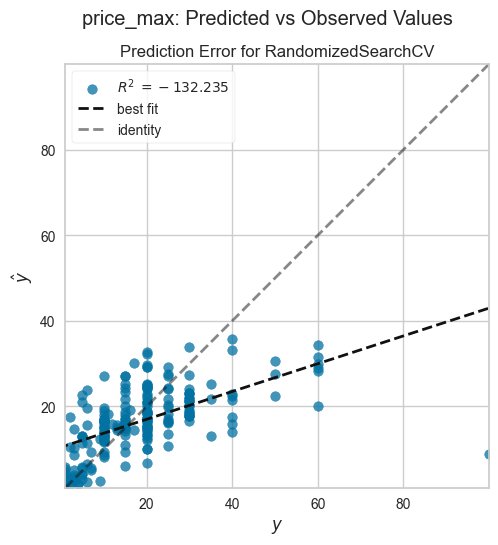

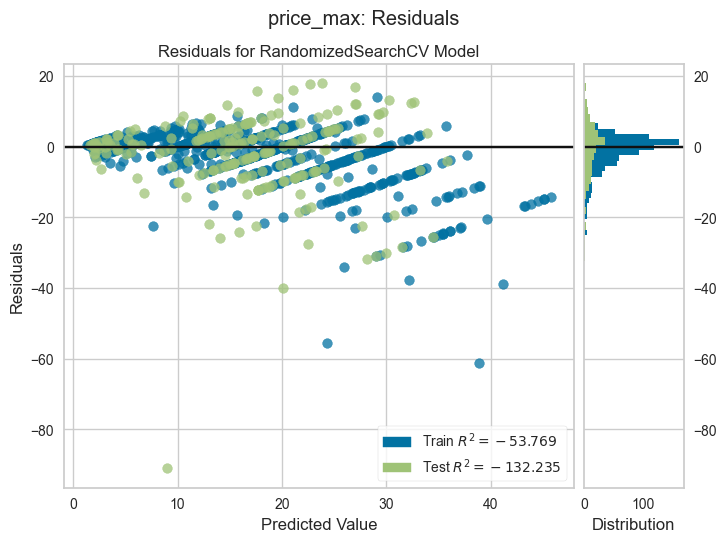

In [51]:
from sklearn.model_selection import train_test_split
import joblib

from analytics_translators.utils.plot import (
    plot_pred_obs,
    plot_residuals
)

cols_target = [col for col in df_all.columns if col in configs.COLS_TARGET]
cols_predictors = [col for col in df_all.columns if col not in configs.COLS_TARGET + configs.COLS_EXCLUDE]
cols_predictors_bool = [col for col in cols_predictors if bool(re.match(configs.REGEX_BOOL_FEATURES, string=col))]
cols_predictors_numeric = [col for col in cols_predictors if col not in cols_predictors_bool]

for target in cols_target:

    try:
        best_model = joblib.load(Path(configs.DIR_MODEL_DEPLOY) / f'model_{target}_best.pkl')
    
        print('_'*50)
        print(target)

        df = df_all.dropna(subset=target).copy()
        
        X = df[[col for col in df.columns if col in cols_predictors]]
        y = df[target]

        # Create training and test set
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                            test_size=configs.TEST_SIZE, 
                                                            random_state=configs.SEED)
        
        display(best_model)

        plot_pred_obs(
            best_model,
            X_train, y_train,
            X_test, y_test,
            name=target,
            show=True
        )

        plot_residuals(
            best_model,
            X_train, y_train,
            X_test, y_test,
            name=target,
            show=True
        )
    except FileNotFoundError:
        next


***
# System Information

In [ ]:
print(sys.version)

In [ ]:
!which python3